#Transfer-Learning: MobileNet

##1. Preparación de los datos

In [3]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  dataset_undersampling/train/Normal/Normal-2451.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2453.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2454.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2455.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2458.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2459.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-246.png             68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2460.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2464.png            68%  OK 
Extracting  dataset_undersampling/train/Normal/Normal-2465.png            68%  OK 
Extracting  dataset

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6533132747525638746, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12848144249493022825
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [12]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Add, Dense, Activation, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

In [6]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Transfer-Learning/MobileNet/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [19]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


##2. MobileNet (Modelo Base)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = MobileNet(weights="imagenet",
                  include_top=False)

base_model.trainable = False 
               
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'MobileNet_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'MobileNet_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 71s 101ms/step - loss: 0.5574 - accuracy: 0.7838 - val_loss: 0.4031 - val_accuracy: 0.8541
Epoch 2/60
412/412 [==============================] - 40s 98ms/step - loss: 0.3905 - accuracy: 0.8551 - val_loss: 0.3653 - val_accuracy: 0.8732
Epoch 3/60
412/412 [==============================] - 40s 98ms/step - loss: 0.3502 - accuracy: 0.8727 - val_loss: 0.3433 - val_accuracy: 0.8762
Epoch 4/60
412/412 [==============================] - 40s 98ms/step - loss: 0.3245 - accuracy: 0.8834 - val_loss: 0.3581 - val_accuracy: 0.8671
Epoch 5/60
412/412 [==============================] - 41s 99ms/step - loss: 0.3086 - accuracy: 0.8872 - val_loss: 0.4270 - val_accuracy: 0.8298
Epoch 6/60
412/412 [==============================] - 41s 99ms/step - loss: 0.2990 - accuracy: 0.8912 - val_loss: 0.3334 - val_accuracy: 0.8777
Epoch 7/60
412/412 [==============================] - 40s 98ms/step - loss: 0.2875 - accuracy: 0.8957 - val_loss: 0.3173 - val_accuracy

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'MobileNet_model.h5')
history = np.load(base_dir + 'MobileNet_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

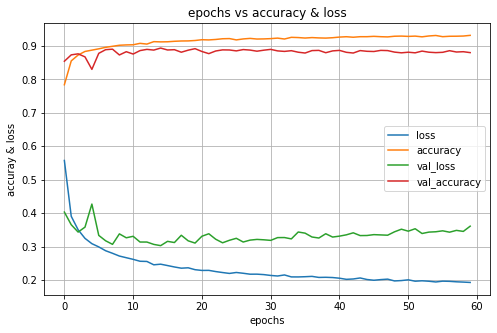

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 8s 80ms/step - loss: 0.3610 - accuracy: 0.8799


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================


y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

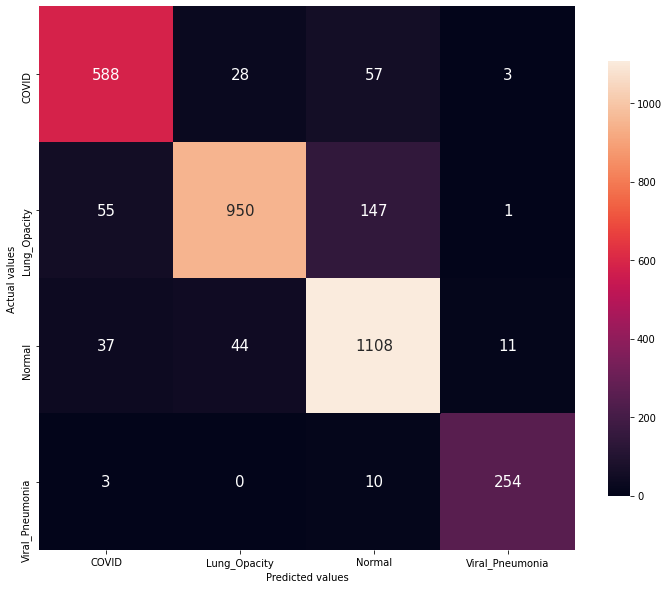

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.86      0.87      0.87       676
   Lung_Opacity       0.93      0.82      0.87      1153
         Normal       0.84      0.92      0.88      1200
Viral_Pneumonia       0.94      0.95      0.95       267

       accuracy                           0.88      3296
      macro avg       0.89      0.89      0.89      3296
   weighted avg       0.88      0.88      0.88      3296



##3. MobileNet (Modelo Base + 2 capas densas)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = MobileNet(weights="imagenet",
                  include_top=False)

base_model.trainable = False                

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## ==============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'MobileNet_Dense_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'MobileNet_Dense_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 43s 101ms/step - loss: 0.6081 - accuracy: 0.7692 - val_loss: 0.3729 - val_accuracy: 0.8607
Epoch 2/60
412/412 [==============================] - 41s 99ms/step - loss: 0.4354 - accuracy: 0.8393 - val_loss: 0.3623 - val_accuracy: 0.8732
Epoch 3/60
412/412 [==============================] - 41s 99ms/step - loss: 0.3877 - accuracy: 0.8585 - val_loss: 0.3203 - val_accuracy: 0.8786
Epoch 4/60
412/412 [==============================] - 41s 99ms/step - loss: 0.3745 - accuracy: 0.8622 - val_loss: 0.3225 - val_accuracy: 0.8835
Epoch 5/60
412/412 [==============================] - 41s 99ms/step - loss: 0.3518 - accuracy: 0.8706 - val_loss: 0.3162 - val_accuracy: 0.8847
Epoch 6/60
412/412 [==============================] - 41s 100ms/step - loss: 0.3213 - accuracy: 0.8858 - val_loss: 0.3341 - val_accuracy: 0.8774
Epoch 7/60
412/412 [==============================] - 41s 99ms/step - loss: 0.3220 - accuracy: 0.8819 - val_loss: 0.2943 - val_accurac

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'MobileNet_Dense_model.h5')
history = np.load(base_dir + 'MobileNet_Dense_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

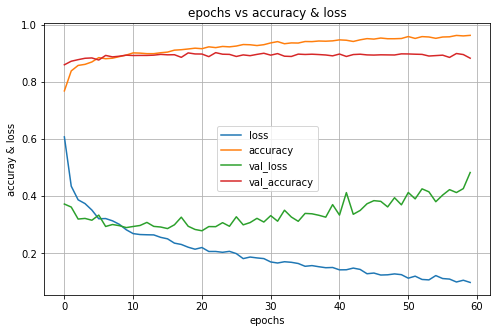

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO 
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 8s 79ms/step - loss: 0.4833 - accuracy: 0.8838


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CAREGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

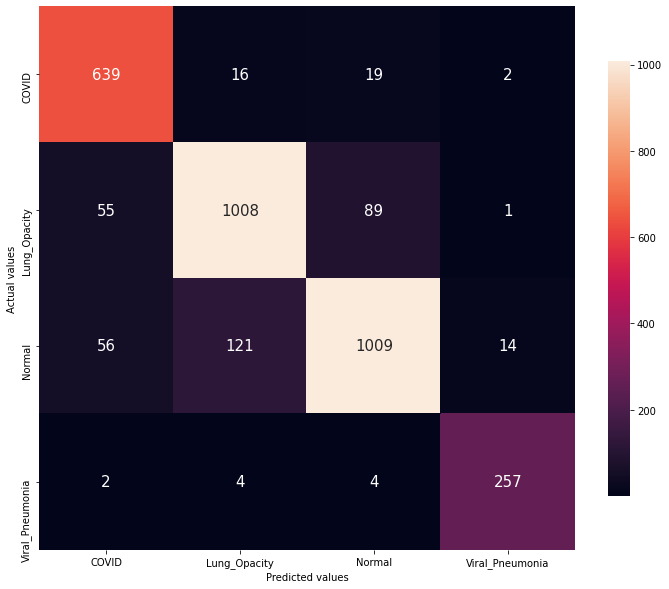

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.85      0.95      0.89       676
   Lung_Opacity       0.88      0.87      0.88      1153
         Normal       0.90      0.84      0.87      1200
Viral_Pneumonia       0.94      0.96      0.95       267

       accuracy                           0.88      3296
      macro avg       0.89      0.91      0.90      3296
   weighted avg       0.88      0.88      0.88      3296



##4. MobileNet (Modelo Base + 2 capas densas + últimas capas desbloqueadas)

In [9]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = MobileNet(weights="imagenet",
                  include_top=False)

base_model.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________

In [10]:
## DESBLOQUEO DE LAS ÚLTIMAS CAPAS CONVOLUCIONALES
## =============================================================================

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['conv_pw_13', 'conv_pw_13_bn']:
        layer.trainable = True
    else:
        layer.trainable = False                     

In [13]:
## AÑADIDO DE DOS CAPAS DENSAS
## =============================================================================

out = GlobalAveragePooling2D()(base_model.output)
out = Dense(1024, activation = 'relu')(out)
out = Dropout(0.4)(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.4)(out)
out = Dense(4, activation='softmax')(out)
model = Model(inputs = base_model.input, outputs = out)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='SGD',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'MobileNet_Last_Layer_Trainable_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=100,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'MobileNet_Last_Layer_Trainable_history.npy', history.history)

Epoch 1/100
412/412 [==============================] - 76s 106ms/step - loss: 0.4972 - accuracy: 0.8206 - val_loss: 0.8110 - val_accuracy: 0.7518
Epoch 2/100
412/412 [==============================] - 42s 101ms/step - loss: 0.2972 - accuracy: 0.8925 - val_loss: 0.9712 - val_accuracy: 0.7461
Epoch 3/100
412/412 [==============================] - 42s 102ms/step - loss: 0.2420 - accuracy: 0.9165 - val_loss: 0.3238 - val_accuracy: 0.8814
Epoch 4/100
412/412 [==============================] - 44s 106ms/step - loss: 0.2079 - accuracy: 0.9284 - val_loss: 0.5119 - val_accuracy: 0.8064
Epoch 5/100
412/412 [==============================] - 42s 101ms/step - loss: 0.1795 - accuracy: 0.9380 - val_loss: 0.6538 - val_accuracy: 0.7867
Epoch 6/100
412/412 [==============================] - 42s 101ms/step - loss: 0.1528 - accuracy: 0.9474 - val_loss: 1.0391 - val_accuracy: 0.7348
Epoch 7/100
412/412 [==============================] - 48s 117ms/step - loss: 0.1380 - accuracy: 0.9521 - val_loss: 4.6645 -

In [15]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'MobileNet_Last_Layer_Trainable_model.h5')
history = np.load(base_dir + 'MobileNet_Last_Layer_Trainable_history.npy', allow_pickle='TRUE').item()

In [16]:
del history['lr']

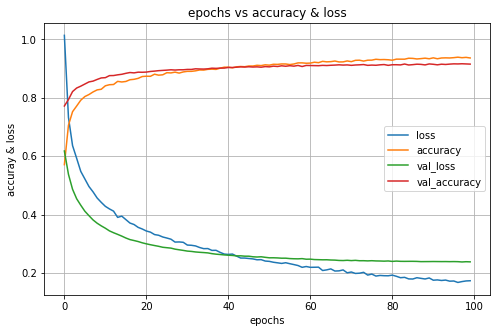

In [17]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [18]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 8s 79ms/step - loss: 0.2381 - accuracy: 0.9157


In [20]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [21]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [22]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

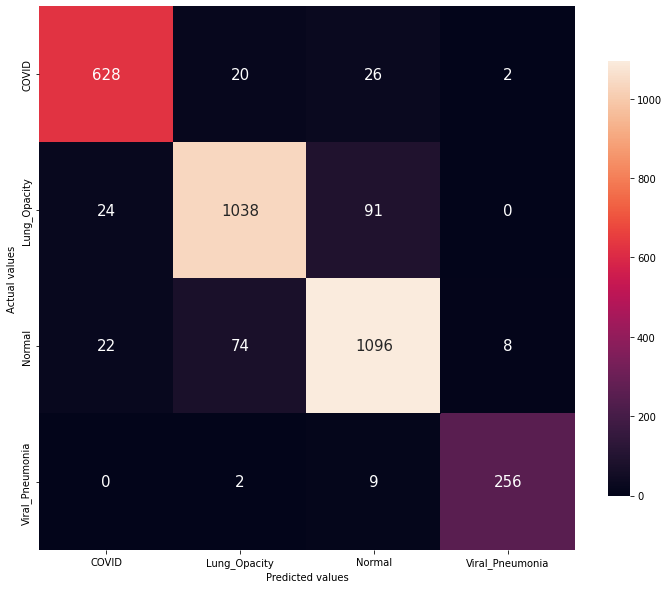

In [23]:
## MATRIZ DE CONFUSIÓN (Visualizacion)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [24]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.93      0.93      0.93       676
   Lung_Opacity       0.92      0.90      0.91      1153
         Normal       0.90      0.91      0.91      1200
Viral_Pneumonia       0.96      0.96      0.96       267

       accuracy                           0.92      3296
      macro avg       0.93      0.93      0.93      3296
   weighted avg       0.92      0.92      0.92      3296

